![title](img/logo.png)
# Biometrics System Concepts
## Assignment 2: Fingerprint and Iris based identification
<b>Name</b>: Charalampos Kalavrytinos |
<b>Student-nr</b>: r0833114 |
<b>Date</b>: April 1, 2021
---

Implement and test a key-point based fingerprint and iris recognition system and fuse the two systems together.

A high-level description is provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

This document is structured as follows:
* [I. Setting](#I.-Setting)
* [II. Fingerprint Recognition](#II.-Fingerprint-Recognition)
  1. Reading data
  2. Baseline model
    1. Choosing a similarity metric
    2. Constructing the similarity matrix
    3. Validation
  3. Model extension 1: local similarity¶
    1. Image enhancements
    2. Feature extraction
    3. local Keypoint Matching
    4. Local Similarity metric
    5. Construct local similarity matrix
    6. Validation
  4. Model extension 2: Global similarity
    1. Image alignment
    2. Global Similarity Metric
    3. Construct global similarity matrix
    4. Validation
  5. Model extension 3: Hybrid features
    1. Hybrid Similarity metric
    2. Construct hybrid similarity matrix
    3. Validation
  6. Solve the murder case
* [III. Iris Recognition](#III.-Iris-recognition)
  1. Reading data
  2. Biometric iris recogntion System
    1. Image enhancement
    2. Construct similarity matrix
    3. Validation
  3. Solve the murder case
* [IV. Multimodal System](#IV-Multimodal-System)
  1. Score fusion
    1. Construct similarity matrix
    2. Validation
  2. Solve the murder case  
* [V. Assignment Instructions](#V.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of algorithmic components, add external python files, ...). Try to keep things structured!

In [1]:
# Imports
%matplotlib inline
import cv2                                          # opencv
import numpy as np                                  # numpy
from matplotlib import pyplot as plt                # for plots
from pathlib import Path                            # for handling paths
import src.fprmodules.enhancement as fe             # local modules for fingerprint enhancement
import pyeer
from sklearn.metrics import roc_curve               # to calculate roc
import pickle
from tqdm.notebook import tqdm as tqdm_notebook     # a visual progress bar library
from IPython.display import Markdown                # allows us to generate markdown using python code
import pandas as pd                                 # library for dataframes
from itertools import product
import math

import glob
import os
import zlib
from base64 import urlsafe_b64encode as b64e, urlsafe_b64decode as b64d
from src import eval as ev

In [2]:
# helper functions (modified)
def plot_image_sequence(data, n, imgs_per_row=7, figsize=(10,10), cmap='gray'):
    """Function used to plot sequence of images using pyplot"""
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(figsize[0]*n_cols,figsize[1]*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i], cmap=cmap)
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i], cmap=cmap)
        else:
            ax[int(i%n)].imshow(data[i], cmap=cmap)
    plt.show()

## I. Setting

Oh no! A woman has been found dead in her hotel room! The forensics team has already been at the crime scene and they are asking for your help to identify the murderer!

The woman was discovered by the hotel staff with multiple stab wounds in the chest. The knife that was probably used to commit this atrocious crime was recovered in the bathroom sink. Looks like the murderer left in a hurry before being able to completely cleanse the weapon, since the forensics team managed to recover a fingerprint on the knife that does not belong to the victim.

Luckily the high-tech hotel has agreed to collaborate and has provided you with 80 fingerprint scans of high quality that the current hotelgoers use to gain access to the hotel and It is a dataset of iris scans and iris scans that are recorded by the security system when someone attempts to access a hotel rooms. You're not sure how legal that is... Your collegue has provided you with some python code that was used for a different case. 

Can you complete the code and find the murderer?

## II. Fingerprint Recognition
### 1. Reading data: Reading image data and converting to gray-scale
Before you get started on anything it is always a good idea to visualise your data. Let's first have a look at the fingerprint that was collected on the murder weapon first... 

Note that we convert the data to grayscale, we're not interested in color values (and don't have them).

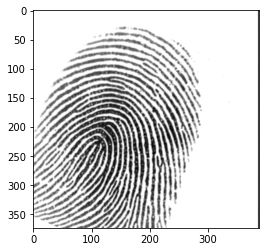

In [3]:
perpetrator_f = cv2.imread('fp_perpetrator.png')                        # fingerprint on murder weapon
assert ((perpetrator_f[:,:,0] == perpetrator_f[:,:,1]).all() 
    and (perpetrator_f[:,:,0] == perpetrator_f[:,:,2]).all())

perpetrator_f = cv2.cvtColor(perpetrator_f, cv2.COLOR_BGR2GRAY)         # color to grayscale
plt.imshow(perpetrator_f, cmap='gray')

Now let's have a look at the other fingerprint data that was provided. It is stored in folder `data/FVC2002/DB1_B/*` with filenames as XXY.tif with XX the individual number and Y the fingerprint number for this individual returns a list of images and a list of associated identity labels. In the code below we have provided a function that returns the data as a 2-tuple of image information and the labels. Have a look!

In [4]:
def read_DB(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)

# select a Database
images_db, labels_db = read_DB('./data/FVC2002/DB1_B/')

# save data properties
n_images = len(images_db)
img_height, img_width = images_db[0].shape[0], images_db[0].shape[1]

Markdown("""
Let's have a look at the dataset... It contains {} images of size {}×{}. Let's visualise some:
""".format(n_images,img_height,img_width))

  0%|          | 0/80 [00:00<?, ?it/s]


Let's have a look at the dataset... It contains 80 images of size 374×388. Let's visualise some:


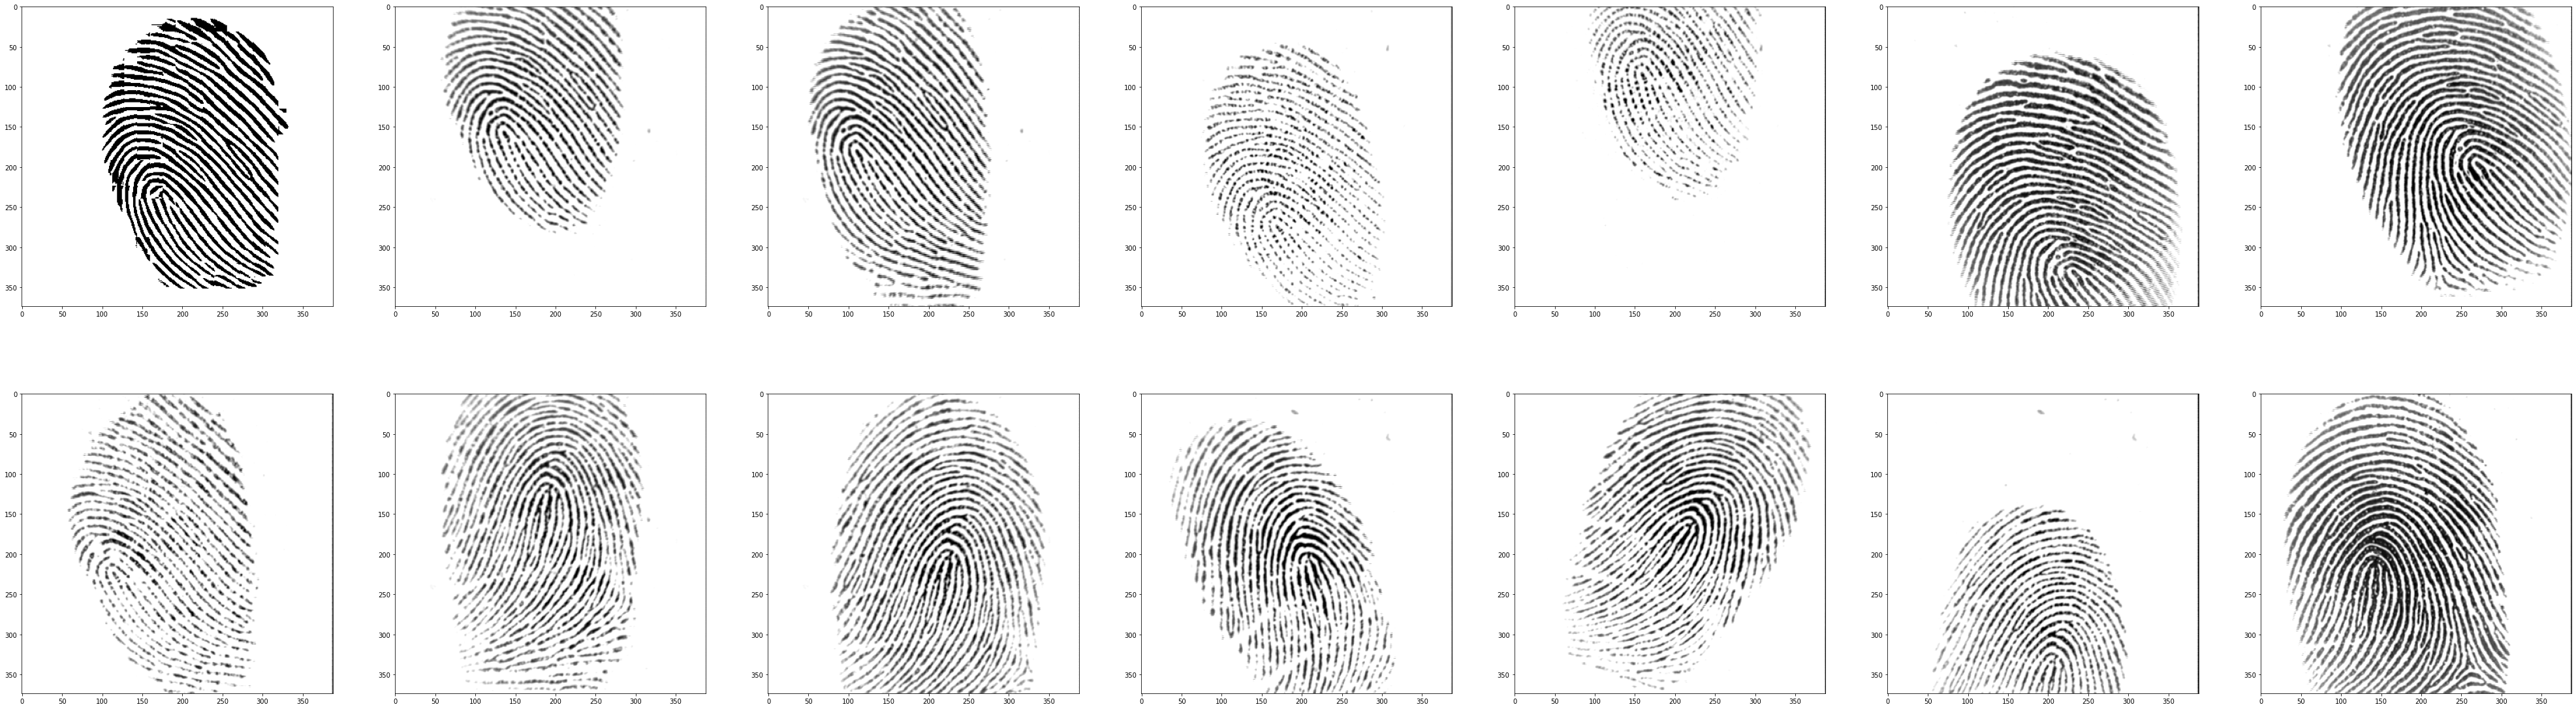

In [5]:
n = 14
plot_image_sequence(images_db, n)

### 2. A baseline model

#### 2.1. Choosing a similarity metric
In your first assignment the similarity metric was already provided, in this assignment you have the chance to play around with distances and similarities yourself! Let's give it a shot!

<div class="alert alert-block alert-success">
<b>Q1: </b> Take a look at the fingerprint similarity function below, is this a good metric to quantify a distance between two fingerprints? What are its limitations?
</div>

In [6]:
from scipy.spatial import distance

mss = lambda x,y: 1/(1+np.square(x-y).mean())
sq_eucl = lambda x,y: np.sum((x-y)**2)
eucl = lambda x,y: math.sqrt(sq_eucl(x, y))
cos = lambda x,y:distance.cosine(x.flatten(),y.flatten())
cheb = lambda x,y: distance.chebyshev(x.flatten(),y.flatten())
corr = lambda x,y: distance.correlation(x.flatten(),y.flatten()) 
#canberr = lambda x,y: distance.canberra(x.flatten(),y.flatten())

#### 2.2. Constructing the similarity matrix
Sadly the amount of data you have is very limited so it is a bad idea to start developing a biometric system based solely on the similarity with that one fingerprint as this might lead you on the wrong path (see overfitting)! Instead let's develop an identification system and evaluate it on all the data we have available.

Once we have a metric, we can just construct the similarity matrix and proceed as in the previous assignment!

In [7]:
def construct_similarity_tensor(img_db, labels, dist_func, exclude_img_duplicates=True):
    #dist_func is the function that computes the distance between two images
    data = []
    n_images = len(img_db)
    for i,j in product(range(n_images), range(n_images)):
        # if comparing the same image
        if exclude_img_duplicates and i == j:
            continue
        data.append([
            labels[i], labels[j],
            dist_func(img_db[i], img_db[j])])
    return pd.DataFrame(data, columns=['s1', 's2', 'd'])

In [8]:
sim_mss_df = construct_similarity_tensor(images_db, labels_db, mss)             # Use mss dist func
#sim_cos_df = construct_similarity_tensor(images_db, labels_db, cos)             # Use cosine dist func
#sim_cheb_df = construct_similarity_tensor(images_db, labels_db, cheb)           # Use chebysev dist func
#sim_eucl_df = construct_similarity_tensor(images_db, labels_db, eucl)           # Use euclidean dist func
#sim_canberr_df = construct_similarity_tensor(images_db, labels_db, canberr)     # Use canberra dist func


However... the setup is not completely the same, in previous session we only had 1 fingerprint per individual, in this setup we have 8. That means we have a total of 64 similarities between individuals! The `construct_distance_df` function does exclude similarity between the same images, resulting in 64-8 images for the diagonal. Why is this? 

First, let us calculate the pivot table based on the length of distances calculated. We observe that there are 8x8 distances for every individual comparison since there are 8 fingerprint images for each individual.

In [9]:
sim_mat_len = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = len)
sim_mat_len

s2    01    02    03    04    05    06    07    08    09    10
s1                                                            
01  56.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0
02  64.0  56.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0
03  64.0  64.0  56.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0
04  64.0  64.0  64.0  56.0  64.0  64.0  64.0  64.0  64.0  64.0
05  64.0  64.0  64.0  64.0  56.0  64.0  64.0  64.0  64.0  64.0
06  64.0  64.0  64.0  64.0  64.0  56.0  64.0  64.0  64.0  64.0
07  64.0  64.0  64.0  64.0  64.0  64.0  56.0  64.0  64.0  64.0
08  64.0  64.0  64.0  64.0  64.0  64.0  64.0  56.0  64.0  64.0
09  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  56.0  64.0
10  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  64.0  56.0

In [10]:
from scipy.stats import hmean
# sim_mat_min = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = min)
# sim_mat_max = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = max)
# sim_mat_mean = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.mean)
# sim_mat_hmean = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = hmean)

sim_mat_min = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = min)
sim_mat_max = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = max)
sim_mat_mean = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.mean)
sim_mat_hmean = sim_mss_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = hmean)

# sim_mat_min = sim_canberr_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = min)
# sim_mat_max = sim_canberr_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = max)
# sim_mat_mean = sim_canberr_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = np.mean)
# sim_mat_hmean = sim_canberr_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = hmean)


Text(0, 0.5, 'individuals')

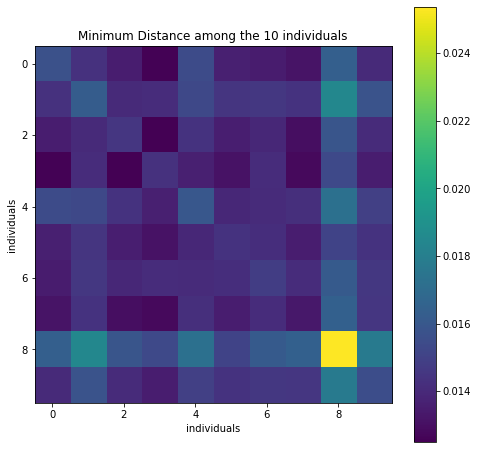

In [11]:
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(sim_mat_min, vmin=sim_mat_min.min().min(), vmax=sim_mat_min.max().max())                 # show min matrix
fig.colorbar(cax)
plt.title('Minimum Distance among the 10 individuals')
plt.xlabel('individuals')
plt.ylabel('individuals')

Text(0, 0.5, 'individuals')

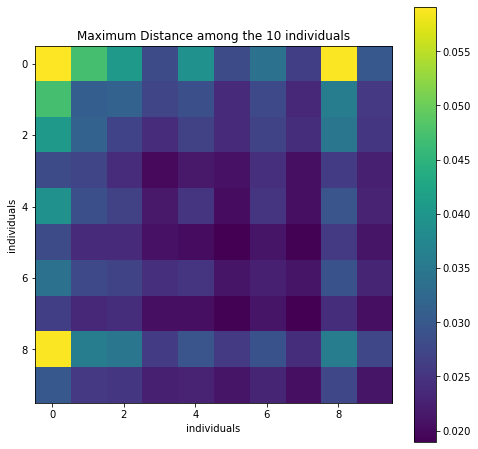

In [12]:
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(sim_mat_max, vmin=sim_mat_max.min().min(), vmax=sim_mat_max.max().max())                 # show max matrix
fig.colorbar(cax)
plt.title('Maximum Distance among the 10 individuals')
plt.xlabel('individuals')
plt.ylabel('individuals')

Text(0, 0.5, 'individuals')

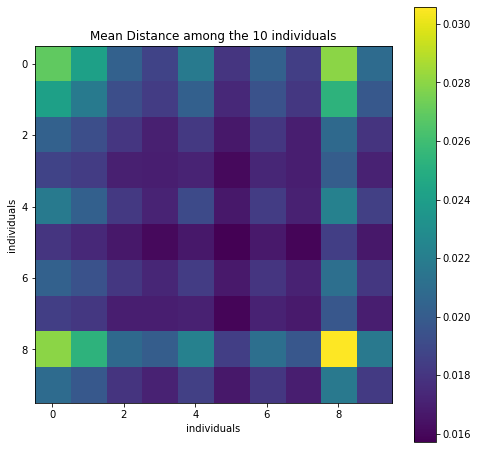

In [13]:
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(sim_mat_mean, vmin=sim_mat_mean.min().min(), vmax=sim_mat_mean.max().max())                 # show mean matrix
fig.colorbar(cax)
plt.title('Mean Distance among the 10 individuals')
plt.xlabel('individuals')
plt.ylabel('individuals')

In [14]:
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(sim_mat_hmean, vmin=sim_mat_hmean.min().min(), vmax=sim_mat_hmean.max().max())                 # show hmean matrix
fig.colorbar(cax)
plt.title('Harmonic mean distance among the 10 individuals')
plt.xlabel('individuals')
plt.ylabel('individuals')

Text(0, 0.5, 'individuals')

<div class="alert alert-block alert-success">
<b>Q2: </b> Find a way to summarise/represent the score data for each pair of individuals, do you see any advantages/disadvantages?
</div>

#### 2.3. Validation of baseline identification system
Now that you've aggregate the similarity information you have a similarity matrix on the individual level. 

In [15]:
"""Let's pick harmonic mean of all 64 distances"""
import src.BSSR1 as BSSR1
sim = sim_mat_hmean
genuine_id, scores = BSSR1.sim2scores(sim)

<div class="alert alert-block alert-success">
<b>Q3: </b> Use the similarity matrix to assess the performance of your system in identification setting. Report on the performance of your baseline.
</div>

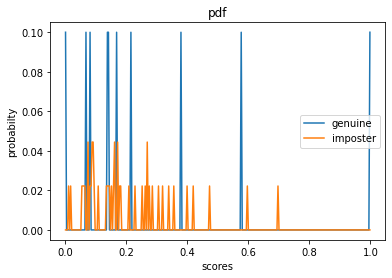

In [16]:
num_subjects = 10
V = ev.Eval_class(num_subjects)
V.plot_distribution([scores[genuine_id.astype(bool)], scores[~genuine_id.astype(bool)]], ['genuine','imposter'])

In [17]:
V.plot_ROC([genuine_id], [scores], ['genuine'])

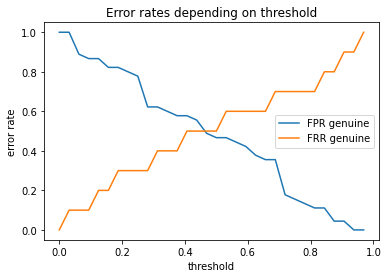

In [18]:
V.plot_errvth([genuine_id], [scores], ['genuine'])
V.plot_det([genuine_id], [scores], ['genuine'])

[0.36363636363636365] [0.7070707070707072]


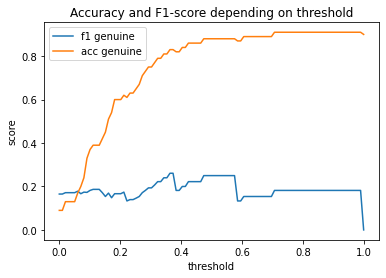

In [19]:
[f1_th_max, acc_th_max] = V.plot_f1_acc([genuine_id], [scores], ['genuine'])
print(f1_th_max, acc_th_max)

In [20]:
V.plot_eer([genuine_id], [scores], ['genuine'])

[15]

In [21]:
auprc_list, ap_list = V.plot_prc([genuine_id], [scores], ['genuine'])

In [22]:
V.plot_cmc([genuine_id], [scores], ['genuine'])

[0.3]

In [23]:
auc = V.calc_auc([genuine_id], [scores])
auc

[0.5133333333333333]

### 3. Model extension 1: local similarity
Ok that was our baseline result but I'm sure we can do much better! 

#### 3.1. Image enhancements
In this next step we re-use code developed by [Utkarsh Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python), to enhance the fingerprint images. It is a Python-recode of Matlab-code developed by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/index.html#fingerprints). I have slightly adapted this code to make it more compliant with OpenCV. It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. Please briefly read through the [github](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python) README.md to better understand what it is doing! 

In [24]:
# Calcuate the enhanced images and the associated segmentation masks
def enhance_images(images):
    images_e_u = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            # Gabor filtering
            img_e, mask, orientim, freqim = fe.image_enhance(image)
            # Normalize in the [0,255] range
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
            images_e_u.append(img_e_u)
        except:
            print('error for: ', i)
            images_e_u.append(image)
            mask = np.ones_like(mask)
        masks.append(mask)
    return np.array(images_e_u), np.array(masks)

if 0:
    images_enhanced_db, masks_db = enhance_images(images_db)
    with open('images_enhanced_db.npy', 'wb') as f:
        np.save(f, images_enhanced_db)
    with open('masks_db.npy', 'wb') as f:
        np.save(f, masks_db)
    print(f"'images_enhanced_db.npy' and 'masks_db.npy' saved!")
else:
    images_enhanced_db = np.load('images_enhanced_db.npy')
    masks_db = np.load('masks_db.npy')
    print(f"'images_enhanced_db.npy' and 'masks_db.npy' loaded!")

'images_enhanced_db.npy' and 'masks_db.npy' loaded!


Note that the images are now much more crisp and that the foreground segmentation was successful even if the technique is rather simple!

In [25]:
n=7
images_segmented_db = [a*b for a,b in zip(images_enhanced_db,masks_db)]
plot_image_sequence(images_db[:n] + images_enhanced_db.tolist()[:n] + masks_db.tolist()[:n] + images_segmented_db[:n], 4*n, n)

#### 3.2. Feature extraction
As you might have noticed by now comparing images on a pixel level is too simple and limited. The basic/traditional fingerprint matching algorithm are based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be determined by first thresholding the FP image and skeletonizing/thinning the enhanced image. For those really interested (but not part of this assignment) in experimenting with such an approach, some code is provided in the fprmodules/minutiae_extraction folder.

Instead, we will rely on establised methods developed in Computer Vision, where the use of keypoint features has proven to be very succesfull (prior to the advent of Deep Learning) in image classification, image alignment and object recognition tasks. A keypoint is a point of interest in an image, it does not necesarily need to be recognisable by a human but it can be. In this project we use keypoints to compare images on 3 levels:
1. Local feature descriptors
2. Global features
3. Hybrid features

To better highlight what is going on we will plot the results on two fingerprint images of the same individual.

In [41]:
# test example
testNr1 = 0
testNr2 = 2

**Keypoint detection** algorithms will result in points of interest on your image, which keypoints are used is dependent on the technique. We will make use of ORB (Oriented FAST and Rotated BRIEF) detection and descriptor algorithm as implemented in [OpenCV ORB](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html#orb).


You are encouraged to try out a series of detection/description/matching algorithms. A short overview of these methods can be found in the OpenCV documentation: [keypoint detection descrption matching](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d). 
Please read these pages carefully and try to understand these methods.

In [56]:
def detect_keypoints(img, mask, keypoint_detector, kernel_size=(5,5)):
    """
        Detects keypoints in an image. 
        
        Note: Many false keypoints will be generated at the edge of the foreground mask, since ridges seem to terminate due to the clipping.
        we remove these by a morpholigical erosion (shrinking) of the foreground mask and deleting the keypoints outside.
    """
    # find the keypoints with ORB
    kp = keypoint_detector.detect(img)
    #convert mask to an unsigned byte
    mask_b = mask.astype(np.uint8)  
    # morphological erosion
    mask_e = cv2.erode(mask_b*255, kernel = np.ones(kernel_size,np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this eroded mask
    kpn = [kp[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255] 
    return kpn

def compute_descriptor(img, kp, detector):
    kp, des = detector.compute(img, kp)
    return des

In [57]:
detector = cv2.ORB_create(nfeatures=100, patchSize=25, edgeThreshold=20)
kps_ORB = [detect_keypoints(images_enhanced_db[i], masks_db[i], detector) for i in range(images_enhanced_db.shape[0])]
des_ORB = [(compute_descriptor(images_enhanced_db[i], kpi, detector)) for i, kpi in zip(range(images_enhanced_db.shape[0]),kps_ORB)]


kp1_ORB = np.array(detect_keypoints(images_enhanced_db[testNr1], masks_db[testNr1], detector))
kp2_ORB = np.array(detect_keypoints(images_enhanced_db[testNr2], masks_db[testNr2], detector))
img1 = cv2.drawKeypoints(images_enhanced_db[testNr1],kp1_ORB,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2 = cv2.drawKeypoints(images_enhanced_db[testNr2],kp2_ORB,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img2)
axarr[1].imshow(img2)
f.suptitle('ORB features for 2 fp of the same individual')

Text(0.5, 0.98, 'ORB features for 2 fp of the same individual')

Text(0.5, 0.98, 'ORB features with rich Kps')

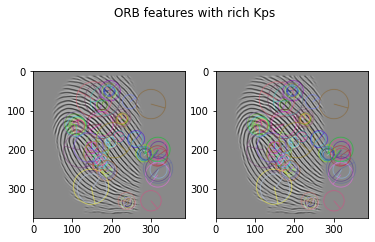

In [43]:
img1 = cv2.drawKeypoints(images_enhanced_db[testNr1],kp1_ORB,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv2.drawKeypoints(images_enhanced_db[testNr2],kp1_ORB,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img2)
axarr[1].imshow(img2)
f.suptitle('ORB features with rich Kps')

In [44]:
detector_sift = cv2.SIFT_create(nfeatures=200, contrastThreshold=0.03)
kps_SIFT = [detect_keypoints(images_enhanced_db[i], masks_db[i], detector_sift) for i in range(images_enhanced_db.shape[0])]
des_SIFT = [(compute_descriptor(images_enhanced_db[i], kpi, detector_sift)) for i, kpi in zip(range(images_enhanced_db.shape[0]),kps_SIFT)]


kp1_SIFT = detect_keypoints(images_enhanced_db[testNr1], masks_db[testNr1], detector_sift)
kp2_SIFT = detect_keypoints(images_enhanced_db[testNr2], masks_db[testNr2], detector_sift)
                            
img1 = cv2.drawKeypoints(images_enhanced_db[testNr1],kp1_SIFT,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2 = cv2.drawKeypoints(images_enhanced_db[testNr2],kp2_SIFT,None,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img2)
axarr[1].imshow(img2)
f.suptitle('SIFT features for 2 fp of the same individual')

Text(0.5, 0.98, 'SIFT features for 2 fp of the same individual')

**The Local Feature descriptor** will give you a vector describing the local region around the key-point in the feature space. Note that these feature descriptors give a vectorial summary of the neighbourhood around each keypoint. A simple metric on these vectors (Euclidean Distance for continuous variables, Hamming Distance for binary variables) can then be used to determine similarity.

<div class="alert alert-block alert-success">
<b>Q4: </b> Visualise the local descriptors. Briefly explain the way the feature descriptor works.
</div>

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
tmp = [pca.fit_transform(item.T).flatten() for item in des_SIFT]
des_SIFT_arr = np.asarray(tmp)

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
tmp = [pca.fit_transform(item.T).flatten() for item in des_ORB]
des_ORB_arr = np.asarray(tmp)

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 847.146940
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.929253
[t-SNE] KL divergence after 500 iterations: 0.332709


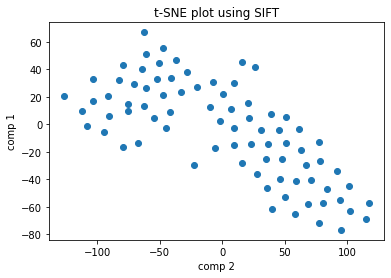

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 894.413670
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.180389
[t-SNE] KL divergence after 500 iterations: 0.755175


In [47]:
from sklearn.manifold import TSNE           # used for dimensionality reduction

def plot_TSNE(features, n_components=2, verbose=1, perplexity=30, n_iter=500, ttl='SIFT'):
    """Function that plots the t-SNE for 2 components. Default features used: facial landmarks for train set"""
    tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(features)
    x,y = tsne_results[:,0], tsne_results[:,1]    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x, y)
    plt.title(f't-SNE plot using {ttl}')
    plt.ylabel("comp 1")
    plt.xlabel("comp 2")
    plt.show()

plot_TSNE(des_SIFT_arr)
plot_TSNE(des_ORB_arr, ttl='ORB')

#### 3.3. local Keypoint Matching

**Keypoint Matchers** match keypoints that have similar descriptors in an image pair and computes the distances between the best matching pairs of keypoints. In this implementation we make use of the brute force matcher of OpenCV, documentation can be found [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher). As a distance between descriptors we make use of the normalised [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance). 

In [58]:
def brute_force_matcher(des1, des2, dist=cv2.NORM_HAMMING):
    """
      Brute Force matcher on a pair of KeyPoint sets using the local descriptor for similarity
      
      returns all pairs of best matches
    """
    
    # crossCheck=True only retains pairs of keypoints that are each other best matching pair
    bf = cv2.BFMatcher(dist, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # sort matches based on descriptor distance
    matches.sort(key=lambda x: x.distance, reverse=False)
    return np.array(matches)

# store the local keypoint matches
local_k1_k2_matches = brute_force_matcher(des_ORB[testNr1], des_ORB[testNr2], cv2.NORM_HAMMING)

# save the source index and target index of the keypoints in the corresponding keypoint sets
local_pt_source, local_pt_target = np.array([(match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T

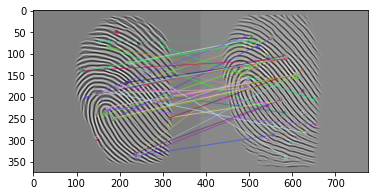

In [60]:
# show the matched keypoints

imMatches = cv2.drawMatches(images_enhanced_db[testNr1],kp1_ORB,
                            images_enhanced_db[testNr2],kp2_ORB,local_k1_k2_matches, None) 
plt.imshow(imMatches)

<div class="alert alert-block alert-info">
<b>Tip:</b> Make sure you spent the proper amount of time on constructing the similarity metrics, a good implementation will save you a lot of time in the long run! </div>

#### 3.4 Local Similarity metric
Now that we have matching keypoints we can define simple scalar measures on this set of distances, such as the number of pairs with a distance smaller than a set threshold, or the sum/mean of the first N distances (ranked from small to larger), etc.

<div class="alert alert-block alert-success">
<b>Q5: </b> Choose a local feature similarity function, (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
</div>

In [61]:
from scipy.stats import hmean
def local_img_similarity(matches, metric='mean_best_N'):
    distances = [m.distance for m in matches]
    N = int(len(distances))
    if metric == 'mean_best_N':
        sim = np.mean(distances[:N])                # just the mean of 10% best distances
    elif metric == 'sum_best_N':
        sim = np.sum(distances[:N])                 # just the sum of 10% best distances
    elif metric == 'hmean_best_of_mean':
        m = np.argwhere(distances<=np.mean(distances))
        sim = hmean(distances[:len(m)])
    return sim

In [66]:
def local_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = np.array(detect_keypoints(fp1, mask1, detector, kernel_size = kp_erosion_ksize))
    kp2 = np.array(detect_keypoints(fp2, mask2, detector, kernel_size = kp_erosion_ksize))
    
    # compute descriptor for each keypoints
    local_des1 = compute_descriptor(fp1, kp1, detector)
    local_des2 = compute_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # distances between matches that are below threshold
    return local_img_similarity(local_k1_k2_matches)
# compute similarity tensor 
sim_bestmean_df = construct_similarity_tensor(np.stack([images_enhanced_db,masks_db],-1), labels_db, local_similarity)

#### 3.5 Construct local similarity matrix 


Text(54.625, 0.5, 'individuals')

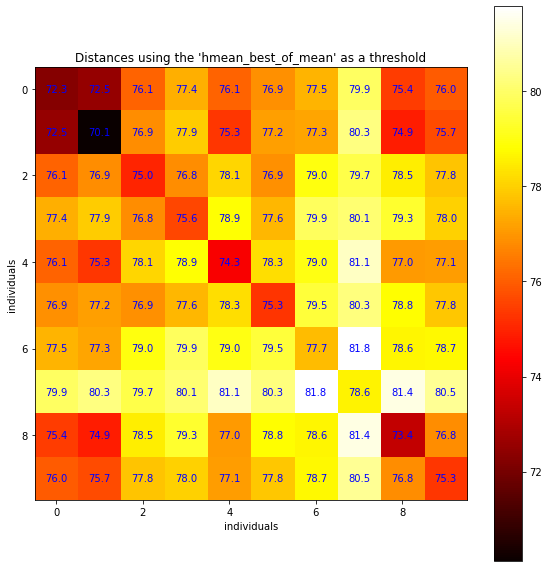

In [71]:
# aggregate similarities
loc_sim_bestmean = sim_bestmean_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = hmean)
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(loc_sim_bestmean, cmap='hot', interpolation='nearest', vmin=loc_sim_bestmean.min().min(), vmax=loc_sim_bestmean.max().max())                 # show hmean matrix
fig.colorbar(cax)
for i in range(loc_sim_bestmean.shape[0]):
    for j in range(loc_sim_bestmean.shape[0]):
        text = ax.text(j, i, round(np.array(loc_sim_bestmean)[i, j],1),
                       ha="center", va="center", color="b")

fig.tight_layout()
plt.title(f"Distances using the 'hmean_best_of_mean' as a threshold")
plt.xlabel('individuals')
plt.ylabel('individuals')

In [72]:
def local_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = np.array(detect_keypoints(fp1, mask1, detector, kernel_size = kp_erosion_ksize))
    kp2 = np.array(detect_keypoints(fp2, mask2, detector, kernel_size = kp_erosion_ksize))
    
    # compute descriptor for each keypoints
    local_des1 = compute_descriptor(fp1, kp1, detector)
    local_des2 = compute_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    return local_img_similarity(local_k1_k2_matches, 'hmean_best_of_mean')            # return distances
    
# compute similarity tensor 
sim_best_of_mean_df = construct_similarity_tensor(np.stack([images_enhanced_db,masks_db],-1), labels_db, local_similarity)

In [74]:
# aggregate similarities
loc_sim_sim_best_of_mean_df = sim_best_of_mean_df.pivot_table(index='s1', columns='s2',values='d',aggfunc = hmean)
fig = plt.figure(figsize=(8,8))                                     # make figure
ax = fig.add_subplot(111)
cax = ax.imshow(loc_sim_sim_best_of_mean_df, cmap='hot', interpolation='nearest', vmin=loc_sim_sim_best_of_mean_df.min().min(), vmax=loc_sim_sim_best_of_mean_df.max().max())                 # show hmean matrix
fig.colorbar(cax)
for i in range(loc_sim_sim_best_of_mean_df.shape[0]):
    for j in range(loc_sim_sim_best_of_mean_df.shape[0]):
        text = ax.text(j, i, round(np.array(loc_sim_sim_best_of_mean_df)[i, j],1),
                       ha="center", va="center", color="b")

fig.tight_layout()
plt.title(f"Distances using the 'best_of_mean' as a threshold")
plt.xlabel('individuals')
plt.ylabel('individuals')

Text(54.625, 0.5, 'individuals')

#### 3.6. Evaluating local model

f1_th_max: [0.21212121212121213], acc_th_max: [0.21212121212121213]
AUC:[0.9488888888888889]


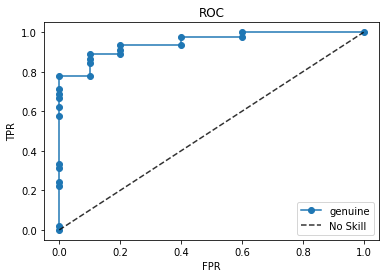

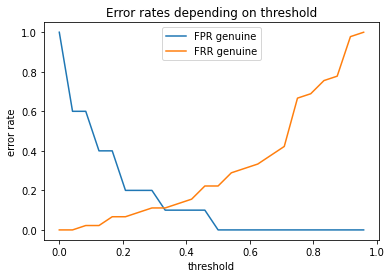

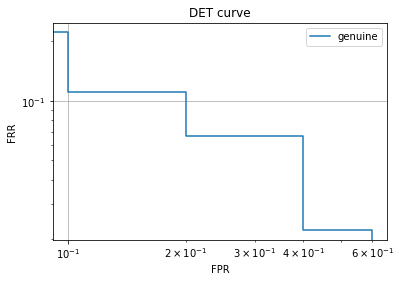

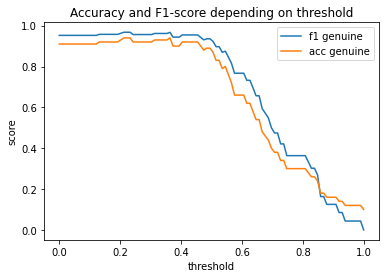

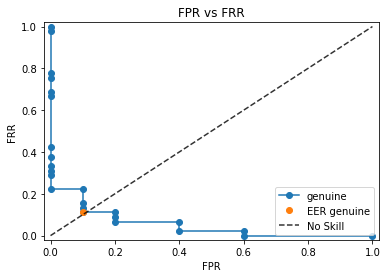

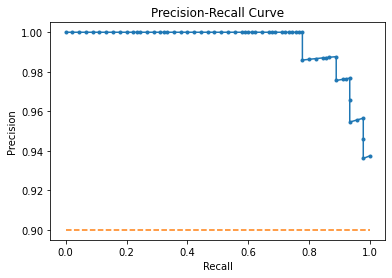

In [85]:
genuine_id, scores = BSSR1.sim2scores(loc_sim_sim_best_of_mean_df)
num_subjects = 10

V = ev.Eval_class(num_subjects)
V.plot_distribution([scores[genuine_id.astype(bool)], scores[~genuine_id.astype(bool)]], ['genuine','imposter'])
V.plot_ROC([~genuine_id.astype(bool)], [scores], ['genuine'])
V.plot_errvth([~genuine_id.astype(bool)], [scores], ['genuine'])
V.plot_det([~genuine_id.astype(bool)], [scores], ['genuine'])
[f1_th_max, acc_th_max] = V.plot_f1_acc([~genuine_id.astype(bool)], [scores], ['genuine'])
print(f'f1_th_max: {f1_th_max}, acc_th_max: {acc_th_max}')
V.plot_eer([~genuine_id.astype(bool)], [scores], ['genuine'])
auprc_list, ap_list = V.plot_prc([~genuine_id.astype(bool)], [scores], ['genuine'])
auc = V.calc_auc([~genuine_id.astype(bool)], [scores])
print(f'AUC:{auc}')

### 4. Model extension 2: Global similarity

**Global features**, here we use the matching keypoints to align the fingerprints, this allows us to compare the images as a whole (globally). Once the images are aligned we can take into account the distance between the key-points in the ambient space (the coordinates of the key-points). This is also referred to as geometrical distance since this is just comparing two points that are part of the intrinsic geometry of the object (no matter how you move the image around the point will move around with it and stay in the same location on the finger).

#### 4.1 Image alignment
[Here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) you can find a description and code how to start from the brute force matching results and estimate the best transformation (from a family of transformations) that aligns the two images. In the example, a homography-type transformation is searched for. However, this has too many degrees of freedom for our application. We substituted this by a more constrained (only 4 degrees of freedom) similarity (partial affine) transformation.

These routines iteratively determine the minimal set of matching points that define a transformation that optimally aligns all other points as well, taking care of outliers at the same time. This method is a very general optimization technique and is called RANSAC, for "RANdom SAmple Consensus". See, apart from many other sources on the internet, [this presentation](http://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf) for further explanation. 

In [88]:
def estimate_affine_transform_by_kps(src_pts, dst_pts):
    """
        Returns the Affine transformation that aligns two sets of points
    """
    transform_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                           method =  cv2.RANSAC, 
                                           confidence = 0.9, 
                                           ransacReprojThreshold = 10.0, 
                                           maxIters = 5000, 
                                           refineIters = 10)
    return transform_matrix, inliers[:,0]

def warp_points(pts, M):
    mat_reg_points = cv2.transform(pts.reshape(-1,1,2), M)
    
    # return transformed keypoint list
    return cv2.KeyPoint.convert(mat_reg_points) 

def warp_img(img, M):
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# estimate the affine transform that aligns the matched keypoints
M, inliers = estimate_affine_transform_by_kps(
    cv2.KeyPoint.convert(kp1_ORB), 
    cv2.KeyPoint.convert(kp2_ORB))

kp1_reg = warp_points(cv2.KeyPoint.convert(kp1_ORB), M)
img1_reg =  warp_img(images_enhanced_db[testNr1], M)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/calib3d/src/ptsetreg.cpp:1028: error: (-215:Assertion failed) count >= 0 && to.checkVector(2) == count in function 'estimateAffinePartial2D'


In [ ]:
kp1[local_pt_target].shape

Let's have a look at the images and keypoints now that the images are aligned

In [ ]:
show_img1 = cv2.drawKeypoints(img1_reg, kp1_reg, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db[testNr2], kp2, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
_=ax[0].imshow(show_img1), ax[1].imshow(show_img2), plt.show()

As you might have noticed the `estimateAffinePartial2D` function does not only return the transformation matrix but also the minimal set of matching points that were used to to determine the transformation. This gives us a better, more refined set of keypoints. 

In [ ]:
global_k1_k2_matches = local_k1_k2_matches[inliers == 1]

imMatches = cv2.drawMatches(img1_reg, kp1_reg, images_enhanced_db[testNr2], kp2, global_k1_k2_matches.tolist(), None)
_ = plt.imshow(imMatches), plt.show()

#### 4.2 Global Similarity Metric

<div class="alert alert-block alert-success">
<b>Q6: </b> Choose a global feature similarity function, (e.g. you can start from euclidean distance between the reduced sets of KeyPoints and count the values above a threshold)
</div>

In [ ]:
def global_img_similarity(matches, reg_kp1, kp2):
    # distance between aligned keypoints
    return None

#### 4.3 Construct global similarity matrix 

In [ ]:
def global_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = detect_keypoints(fp1, mask1, detector, kernel_size = kp_erosion_ksize)
    kp2 = detect_keypoints(fp2, mask2, detector, kernel_size = kp_erosion_ksize)
    
    # compute descriptor for each keypoints
    kp1, local_des1 = compute_local_descriptor(fp1, kp1, detector)
    kp2, local_des2 = compute_local_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # get source and target index for each match
    local_pt_source, local_pt_target = np.array([
        (match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T
    
    # use matching keypoints to estimate an affine transform between keypoints
    M, inliers = estimate_affine_transform_by_kps(
        cv2.KeyPoint.convert(kp1[local_pt_source]), 
        cv2.KeyPoint.convert(kp2[local_pt_target]))
    
    # if no inliers can be found
    if M is None: 
        return 0
    
    # warp the keypoints according to the found transform
    kp1_reg = warp_points(cv2.KeyPoint.convert(kp1), M)
    
    # subset the keypoints, inliers are considered good keypoints
    # since they were used in finding the transformation
    global_k1_k2_matches = local_k1_k2_matches[inliers == 1]
    
    # compute global similarity based aligned matching global keypoints
    return global_img_similarity(global_k1_k2_matches,kp1_reg, kp2)
 
# compute similarity tensor 
sim_df2 = construct_similarity_tensor(np.stack([images_enhanced_db,masks_db],-1), labels_db, global_similarity)

In [ ]:
# aggregate features


#### 4.4. Evaluate global model

### 5. Model extension 3: Hybrid features

#### 5.1 Hybrid Similarity metric

<div class="alert alert-block alert-success">
<b>Q7: </b> Choose a hybrid feature similarity function that makes use of both the geometric distance and the feature distance of the keypoints.
</div>

In [ ]:
def hybrid_img_similarity(matches, kp1_reg, kp2):
    # distance between aligned keypoints combined with feature distance
    return None

#### 5.2 Construct hybrid similarity matrix

In [ ]:
def hybrid_similarity(masked_fp1, masked_fp2, detector=cv2.ORB_create(), kp_erosion_ksize = (5,5)):
    # separate the semgentation from the image
    fp1, mask1 = masked_fp1[...,0], masked_fp1[...,1] 
    fp2, mask2 = masked_fp2[...,0], masked_fp2[...,1] 
    
    # detect the keypoints
    kp1 = detect_keypoints(fp1, mask1, detector, kernel_size=kp_erosion_ksize)
    kp2 = detect_keypoints(fp2, mask2, detector, kernel_size= kp_erosion_ksize)
    
    # compute descriptor for each keypoints
    kp1, local_des1 = compute_local_descriptor(fp1, kp1, detector)
    kp2, local_des2 = compute_local_descriptor(fp2, kp2, detector)
    
    # find matches between keypoints based on local feature descriptor
    local_k1_k2_matches = brute_force_matcher(local_des1, local_des2, cv2.NORM_HAMMING)
    
    # get source and target index for each match
    local_pt_source, local_pt_target = np.array([
        (match.queryIdx, match.trainIdx) for match in local_k1_k2_matches]).T
    
    # use matching keypoints to estimate an affine transform between keypoints
    M, inliers = estimate_affine_transform_by_kps(
        cv2.KeyPoint.convert(kp1[local_pt_source]), 
        cv2.KeyPoint.convert(kp2[local_pt_target]))
    
    # if no inliers can be found
    if M is None: 
        return 0
    
    # warp the keypoints according to the found transform
    kp1_reg = warp_points(cv2.KeyPoint.convert(kp1), M)
    
    # subset the keypoints, inliers are considered good keypoints
    # since they were used in finding the transformation
    global_k1_k2_matches = local_k1_k2_matches[inliers == 1]

     # compute hybrid similarity based on aligned matching keypoints
    return hybrid_img_similarity(global_k1_k2_matches, kp1_reg, kp2)
    
sim_df3 = construct_similarity_tensor(np.stack([images_enhanced_db,masks_db],-1), labels_db, hybrid_similarity)

In [ ]:
# aggregate features


#### 5.3. Evaluate hybrid model

### 6. Solve the murder case

<div class="alert alert-block alert-success">
<b>Q8: </b> Use your fingerprint biometric system to solve the murder case (find the subject whos fingerprint is closest to <code>perpetrator_f</code>)! Do you feel confident in your prediction? If not, provide 3 reasons on why your performance might be off. If you are, think of a way to quantify your certainty and report on it.  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Remember to use the same preprocessing steps on the perpetrator image! </div>

## III. Iris recognition
Now let's create a biometric system for the iris data. 

In [ ]:
# set path
iris_data_path = 'data/CASIA1/CASIA Iris Image Database (version 1.0)'

### 1. Reading data

<div class="alert alert-block alert-success">
<b>Q9: </b> Plot <code>iris_perpetrator.png</code>. Where do you see difficulties? what kind of similarity measures do you expect to work best?
</div>

Let's read the iris data... From the README: The images are stored as：XXX \ S \ XXX_S_Y.bmp XXX: the unique identifier of eye, range from 000 to 108. S: the index of session.‘1’denotes the first session and‘2’the second session. Y: the index of image in the same session. Range from 1 to 3 in the first session, 1 to 4 in the second session. Therefore XXX_S_Y.bmp means the iris image with index Y in session S from eye XXX.

In [ ]:
def read_iris_DB(path):
    images = []
    labels = []
    imagePaths = sorted(glob.glob(os.path.join(path, '*/1/*.bmp')))
    for imagePath in imagePaths:
        label = imagePath.split('/')[-3]
        image = cv2.imread(imagePath)
        
        # we only read data of the first 10 subjects
        if label == '011':
            break
        
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        images.append(image)
        labels.append(label[1:])

    return np.array(images), np.array(labels)

# read iris Database
iris_images, iris_labels = read_iris_DB(iris_data_path)

# save data properties
n_images = len(iris_images)
img_height, img_width = iris_images[0].shape[0], iris_images[0].shape[1]

Markdown("""
Let's have a look at the dataset... It contains {} images of size of the images is {}×{}. Let's visualise the first n:
""".format(n_images,img_height,img_width))

In [ ]:
n = 14
plot_image_sequence(iris_images, n)

### 2. Biometric iris recogntion System
#### 2.1. Image enhancement
Similar to the image enhancement in the [fingerprints](#3.1.-Image-enhancements) section, we will use [open source code](https://github.com/thuyngch/Iris-Recognition) to segment (based on Daugman's intefro-differential) and normalise (by unwraping the circular region) the iris images. We strongly encourage you to go through the source code or github repository to learn more. 

Also similar to the fingerprint section we enhance the images using a gabor filter bank, this time we implement this using [OpenCV](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gae84c92d248183bd92fa713ce51cc3599). 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from src.irismodules.iris_recognition.python.fnc import segment, normalize

# we use the same hyper parameters as in the enroll-casia1.py example
# feel free to play around with these!
eyelashes_thres = 80
radial_res = 200
angular_res = 400

def segment_iris(img):
    # Segment the iris region from the eye image. Indicate the noise region.
    ciriris, cirpupil, imwithnoise = segment.segment(img)

    # Normalize iris region by unwraping the circular region into a rectangular block of constant dimensions.
    polar_iris, mask = normalize.normalize(
        imwithnoise, ciriris[1], ciriris[0], ciriris[2], cirpupil[1], cirpupil[0], cirpupil[2], radial_res, angular_res)
    
    return polar_iris, (mask == 0)      

def get_filter_bank():
    # this filterbank comes from https://cvtuts.wordpress.com/
    filters = []
    ksize = 5
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
    
def enhance_iris(img, eps = 1.e-15, agg_f = np.max):
    # get the gabor filters
    filters = get_filter_bank()

    # apply filters to image
    enhanced_image = np.array([cv2.filter2D(img, ddepth = -1, kernel=k) for k in filters])
    
    # Normalize in the [0,255] range
    enhanced_image = cv2.normalize(enhanced_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
    
    # aggregate features
    return agg_f(enhanced_image,0)
    
def enhance_and_segment_irises(images):
    enhanced_images, masks = [], []
    for img in images:
        normalised_img, mask = segment_iris(img)
        enhanced_img = enhance_iris(normalised_img)
        
        masks.append(mask)
        enhanced_images.append(enhanced_img)
    
    return np.array(enhanced_images), np.array(masks)
        
enhanced_iris, mask_iris = enhance_and_segment_irises(iris_images)

In [ ]:
n=4

iris_segmented_db = np.array([a*b for a,b in zip(enhanced_iris, mask_iris)])
plot_image_sequence(enhanced_iris.tolist()[:n] + mask_iris.tolist()[:n] + iris_segmented_db.tolist()[:n], 3*n, n, figsize= (10,5), cmap='viridis')

#### 2.2. Construct similarity matrix

<div class="alert alert-block alert-success">
<b>Q10: </b> Construct the similarity matrix based on local, global <u>or</u> hybrid features. Your choice! 
</div>

#### 2.3. Model evaluation
Now evaluate your model

### 3. Solve the murder case

<div class="alert alert-block alert-success">
<b>Q11: </b> Use your iris biometric system to solve the murder case! Do you feel confident in your prediction?
</div>

## IV Multimodal System

### 1. Score Fusion

<div class="alert alert-block alert-success">
<b>Q12: </b> Fuse your iris and fingerprint biometric system on the score level to solve the murder case! Do you feel confident in your prediction? How do you fuse the scores? Why?
</div>

#### 1.1. Construct similarity matrix

#### 1.2. Model evaluation


### 2. Solve the murder case

## V. Assignment Instructions
Both a report and the implementation in this notebook have to be submitted to toledo. <u>The notebook functions as supplementary material only!</u> The report should be self contained. Feel free to add figures, code and mathematics in the report if you feel comfortable. Try to be concice and to the point!  

1. Follow the instructions in the notebook and discuss results/impact in your report.
2. <b>Choose a number of tasks equivalent to <u>at least 5pts</u> from the list below (pts are not related to the grades): </b>
    1. [FING and IRIS] OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints or iris dataset (you can skip the ones that require a lisence). (1pt)
    2. [FING or IRIS] Evaluate your biometric system on 3 other datasets (you can find a lot of unused data in the data directory or on the internet) (1pt)
    3. [FING and IRIS] Evaluate your biometric system in an authentication scenario, do you still aggregate the similarity scores? Why? (1pt)
    5. [IRIS] Play around with the gabor filter bank, what is the effect of the parameters? Can you setup a databank that results in better features? (1pt)
    6. [IRIS] Can you find a better way to aggregate the gabor feature maps? Analyse and report. (1pt)
    6. [IRIS] Compare local hybrid and global features for the iris data (1pt).
    3. [FING or IRIS] Attempt to improve the segmentation, evaluate. (2pt)
    4. [FING or IRIS] Attempt to improve the registration procedure. (2pt)
    6. [FING or IRIS] Attempt to improve the feature extraction using a completely different technique. Evaluate your results. (2pt) 
    7. [MULTI] Fuse your modalities on the feature level instead of the score level (2pt)
    7. [ . ] Create a biometric identification or authentication system on a modality of choice and evaluate it (5pt)
        - e.g. on smartphone usage patterns 
        - Excludes; Fingerprints, irises and faces
    8. [FING or IRIS] Create a machine learning based identification/authentication system and evaluate it (5pt)
        - e.g. based on deep learning 
        - training is required, transfer learning is allowed 
3. All results should be discussed in detail in your report. 


<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em> <br>
<em>Note 2: Usually there are multiple valid solutions, you should always defend your approach and verbally compare it to the other approaches (possible advantages/disadvantages) in your report! If you do not provide proper reasoning we can not give you the grades you deserve! </em>

Good luck, have fun!

## Acknowledgements
1) We use the Fingerprint Verification Competition'2002 Database ([FVC'2002](http://bias.csr.unibo.it/fvc2002/default.asp)). This was the second in a series of benchmark tests that were made publically available. While we do not have access to the full (880 images) database, a subset is freely accessible.

2) We use the CASIA1 Iris database [CASIA1](http://www.cbsr.ia.ac.cn/irisdatabase/irisdatabase.php). You can find more information [here](http://www.cbsr.ia.ac.cn/IrisDatabase.htm).